<a href="https://colab.research.google.com/github/yashsakhuja/Customer-Lifetime-Value-Model/blob/main/CLTV_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Lifetime Value Prediction Probabilistic Model

BG/NBD model for predicting future transactions and churn.

Gamma-Gamma model for future monetary value.

## Importing Packages

In [ ]:
#Importing Necessary Packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import altair as alt

!pip install lifetimes
import lifetimes

from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive


from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00


In [ ]:
import random

# Set the random seed to a specific value, for example, 42
random.seed(42)

## Importing Data

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1E1gDj-3Jt9W0gSGGfiUUEDmw6PQi5nZU/view?usp=drive_link'

import pandas as pd

# to get the id part of the file
id = link.split("/")[-2]
print(id)

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Sales data.csv')

df = pd.read_csv('Sales data.csv',encoding="utf-8")

1E1gDj-3Jt9W0gSGGfiUUEDmw6PQi5nZU


<ipython-input-4-4d94e1f51707>:12: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Sales data.csv',encoding="utf-8")


## Viewing & Understanding Data

In [ ]:
df

ˇItem Name   Item Sub Category  \
0       Fender Deluxe Series Instruments Cable Straigh...  Guitar Accessories   
1       Fender Deluxe Series Instruments Cable Straigh...  Guitar Accessories   
2       Fender Deluxe Series Instrument Cable Straight...  Guitar Accessories   
3       Hercules Guitar Hanger with Wood Block Wall Mo...  Guitar Accessories   
4       Hercules Guitar Hanger with Wood Block Wall Mo...  Guitar Accessories   
...                                                   ...                 ...   
250221  TOURTECH TTS-GA108BK Acoustic / Electric Guita...  Guitar Accessories   
250222              Fender Mojo Grip 3 Pack Dura Tone .58  Guitar Accessories   
250223      Sire Larry Carlton S3 HSS in Tobacco Sunburst    Electric Guitars   
250224              TC Electronic BQ500 Compact Bass Head  Bass Amps and Cabs   
250225           Hercules Travelite Electric Guitar Stand  Guitar Accessories   

       Item Category       UK Region Postcode district Product code  \
0            GUITARS  Greater London          Dartford    990820094   
1            GUITARS  Greater London          Dartford    990820094   
2            GUITARS  Greater London          Dartford    990820089   
3            GUITARS  Greater London          Dartford  GSP38WBPLUS   
4            GUITARS  Greater London          Dartford  GSP38WBPLUS   
...              ...             ...               ...          ...   
250221       GUITARS      South East           Reading  TTS-GA108BK   
250222       GUITARS      South East           Reading   1985351402   
250223       GUITARS  Greater London           Bromley         S3TS   
250224       GUITARS      South West         Salisbury        TC212   
250225       GUITARS      South West         Salisbury       GS302B   

                Brand Sale type   Order ID  Paid Gross  Paid Net  \
0              Fender     Store   86993251       13.99     11.66   
1              Fender     Store   86993251       13.99     11.66   
2              Fender     Store   86993251       17.99     14.99   
3            Hercules     Store   66992989       16.99     14.16   
4            Hercules     Store   66992989       16.99     14.16   
...               ...       ...        ...         ...       ...   
250221       Tourtech       Web  886775996       11.99      9.99   
250222         Fender       Web  886775996        5.99      4.99   
250223           Sire       Web  887436657      369.00    307.50   
250224  TC Electronic       Web  887650314      279.00    232.50   
250225       Hercules       Web  887240171       19.99     16.66   

        Item Discount Net  Item Qty Customer ID      Invoice Date  \
0                     0.0         1   884538136  09/07/2022 13:17   
1                     0.0         1   884538136  09/07/2022 13:17   
2                     0.0         1   884538136  09/07/2022 13:17   
3                     0.0         1   884538136  09/07/2022 11:30   
4                     0.0         1   884538136  09/07/2022 11:30   
...                   ...       ...         ...               ...   
250221                0.0         1   885235237  28/02/2022 00:00   
250222                0.0         1   885235237  28/02/2022 00:00   
250223                0.0         1   887436362  03/02/2023 16:08   
250224                0.0         1   886355493  07/06/2023 10:08   
250225                0.0         1   886355493  15/11/2022 10:37   

        Delivery Net ga:sourceMedium - Split 3  
0                NaN                       NaN  
1                NaN                       NaN  
2                NaN                       NaN  
3                NaN                       NaN  
4                NaN                       NaN  
...              ...                       ...  
250221          4.16                       NaN  
250222          4.16                       NaN  
250223          0.00                   organic  
250224          0.00                       cpc  
250225          4.16                

In [ ]:
df['Customer ID'] = df['Customer ID'].astype(str).str.strip()
df['Order ID'] = df['Order ID'].astype(str).str.strip()

In [ ]:
print(df.shape)
df.describe()

(250226, 17)


Paid Gross       Paid Net  Item Discount Net       Item Qty  \
count  250226.000000  250226.000000      250226.000000  250226.000000   
mean      191.924541     160.784274           0.888604       1.105648   
std       386.028230     324.425040           6.211008       0.610977   
min         0.000000       0.000000           0.000000       1.000000   
25%        14.990000      12.490000           0.000000       1.000000   
50%        59.000000      49.170000           0.000000       1.000000   
75%       199.000000     165.830000           0.000000       1.000000   
max     11299.000000    9415.830000        1083.330000      56.000000   

        Delivery Net  
count  203199.000000  
mean        2.060149  
std        18.798311  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         4.160000  
max      8333.330000

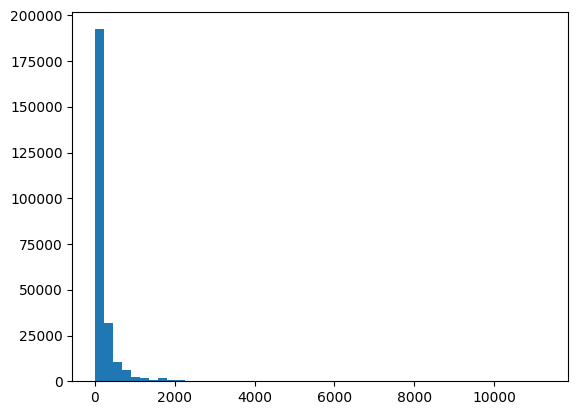

In [ ]:
plt.hist(df['Paid Gross'],bins=50)
plt.show()

In [ ]:
#Distinct Customer IDs
df['Customer ID'].nunique()

96667

In [ ]:
#Date Ranges

#Datetime to date
# Convert 'Invoice Date' column to datetime
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'], format='%d/%m/%Y %H:%M')

# Extract date portion
df['Extracted Invoice Date'] =  df['Invoice Date'].dt.strftime('%Y/%m/%d')

In [ ]:
print(min(df['Extracted Invoice Date']))
print(max(df['Extracted Invoice Date']))

2022/01/02
2023/06/14


In [ ]:
# Group by the year of the 'Extracted Invoice Date' column and count distinct 'Customer ID's
result = df.groupby(df['Invoice Date'].dt.year)['Customer ID'].nunique()
print(result)

Invoice Date
2022    74061
2023    33963
Name: Customer ID, dtype: int64


In [ ]:
daily_customers=df.groupby(df['Extracted Invoice Date'])['Customer ID'].nunique()
daily_sales=df.groupby(df['Extracted Invoice Date'])['Paid Gross'].sum()

daily_data_df = pd.DataFrame({
    'Date': daily_customers.index,
    'Unique Customers': daily_customers.values,
    'Total Paid Gross': daily_sales.values
})

print(daily_data_df.head())

         Date  Unique Customers  Total Paid Gross
0  2022/01/02               394          91417.63
1  2022/01/03               681         213081.08
2  2022/01/04               437         132350.02
3  2022/01/05               405         124104.42
4  2022/01/06               447         134432.33


In [ ]:
daily_data_df

Date  Unique Customers  Total Paid Gross
0    2022/01/02               394          91417.63
1    2022/01/03               681         213081.08
2    2022/01/04               437         132350.02
3    2022/01/05               405         124104.42
4    2022/01/06               447         134432.33
..          ...               ...               ...
518  2023/06/10               170          53196.44
519  2023/06/11               188          47996.80
520  2023/06/12               220          62866.77
521  2023/06/13               210          58534.69
522  2023/06/14               310         110589.32

[523 rows x 3 columns]

In [ ]:
# Create Altair chart
a_chart = alt.Chart(daily_data_df).mark_line().encode(
    x='Date:T',  # Date on the x-axis
    y='Total Paid Gross:Q',  # Total Paid Gross on the y-axis
    tooltip=['Date:T', 'Total Paid Gross:Q']  # Tooltip to display Date and Total Paid Gross
).properties(
    width=900,
    height=400,
    title='Daily Total Paid Gross Trend'
).configure_title(
    fontSize=16,
    fontWeight='bold'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

a_chart

alt.Chart(...)

In [ ]:
# Create Altair chart
b_chart = alt.Chart(daily_data_df).mark_line().encode(
    x='Date:T',  # Date on the x-axis
    y='Unique Customers:Q',  # Unique Customers on the y-axis
    tooltip=['Date:T', 'Unique Customers:Q']  # Tooltip to display Date and Unique Customers
).properties(
    width=900,
    height=400,
    title='Daily Unique Customer Trend'
).configure_title(
    fontSize=16,
    fontWeight='bold'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

b_chart

alt.Chart(...)

## Prepping data for models

In [ ]:
df.head()

ˇItem Name   Item Sub Category  \
0  Fender Deluxe Series Instruments Cable Straigh...  Guitar Accessories   
1  Fender Deluxe Series Instruments Cable Straigh...  Guitar Accessories   
2  Fender Deluxe Series Instrument Cable Straight...  Guitar Accessories   
3  Hercules Guitar Hanger with Wood Block Wall Mo...  Guitar Accessories   
4  Hercules Guitar Hanger with Wood Block Wall Mo...  Guitar Accessories   

  Item Category       UK Region Postcode district Product code     Brand  \
0       GUITARS  Greater London          Dartford    990820094    Fender   
1       GUITARS  Greater London          Dartford    990820094    Fender   
2       GUITARS  Greater London          Dartford    990820089    Fender   
3       GUITARS  Greater London          Dartford  GSP38WBPLUS  Hercules   
4       GUITARS  Greater London          Dartford  GSP38WBPLUS  Hercules   

  Sale type  Order ID  Paid Gross  Paid Net  Item Discount Net  Item Qty  \
0     Store  86993251       13.99     11.66                0.0         1   
1     Store  86993251       13.99     11.66                0.0         1   
2     Store  86993251       17.99     14.99                0.0         1   
3     Store  66992989       16.99     14.16                0.0         1   
4     Store  66992989       16.99     14.16                0.0         1   

  Customer ID        Invoice Date  Delivery Net ga:sourceMedium - Split 3  \
0   884538136 2022-07-09 13:17:00           NaN                       NaN   
1   884538136 2022-07-09 13:17:00           NaN                       NaN   
2   884538136 2022-07-09 13:17:00           NaN                       NaN   
3   884538136 2022-07-09 11:30:00           NaN                       NaN   
4   884538136 2022-07-09 11:30:00           NaN                       NaN   

  Extracted Invoice Date  
0             2022/07/09  
1             2022/07/09  
2             2022/07/09  
3             2022/07/09  
4             2022/07/09

### Splitting the Datasets

In [ ]:
#We will split data for 2022 and 2023 and try to predict the 5 months for 2023 and compare with
#how much the customer atually generates in that period.

df_2022 = df[(df['Extracted Invoice Date'] >= '2022/01/01') & (df['Extracted Invoice Date'] <= '2022/12/31')]
df_2023 = df[(df['Extracted Invoice Date'] >= '2023/01/01') & (df['Extracted Invoice Date'] <= '2023/05/31')]

print(min(df_2022['Extracted Invoice Date']))
print(max(df_2022['Extracted Invoice Date']))

print('----------')

print(min(df_2023['Extracted Invoice Date']))
print(max(df_2023['Extracted Invoice Date']))

print('----------')

print(df_2022.shape)
print(df_2023.shape)

2022/01/02
2022/12/31
----------
2023/01/02
2023/05/31
----------
(178687, 18)
(65918, 18)


In [ ]:
df_2022.columns

Index(['ˇItem Name', 'Item Sub Category', 'Item Category', 'UK Region',
       'Postcode district', 'Product code', 'Brand', 'Sale type', 'Order ID',
       'Paid Gross', 'Paid Net', 'Item Discount Net', 'Item Qty',
       'Customer ID', 'Invoice Date', 'Delivery Net',
       'ga:sourceMedium - Split 3', 'Extracted Invoice Date'],
      dtype='object')

### Creating Summary Data

In [ ]:
summary = lifetimes.utils.summary_data_from_transaction_data(df_2022,'Customer ID','Invoice Date','Paid Gross')
summary = summary.reset_index()
summary.head()

#recency and frequency =0 means they are 'one-time' buyers

Customer ID  frequency  recency      T  monetary_value
0    10000058        1.0     35.0  214.0       21.990000
1    10000227        5.0    178.0  221.0       25.026000
2    10000506        0.0      0.0  315.0        0.000000
3    10000657        9.0    344.0  362.0      814.436667
4    10000670        1.0    117.0  212.0        6.990000

In [ ]:
summary = summary.reset_index(drop=True)

### Frequency Stats

In [ ]:
print(summary['frequency'].describe())

pct_onetimebuy= round(((sum(summary['frequency']==0)/float(len(summary)))*100),2)
print("Percentage of one time buyers", pct_onetimebuy,'%')

alt.data_transformers.enable('default', max_rows=None)

frequency_buy = alt.Chart(summary).mark_bar().encode(
    alt.X('frequency:Q', bin=alt.Bin(step=1), title='Frequency buyers'),
    alt.Y('count():Q', title='Frequency'), tooltip=['frequency:Q', 'count():Q']
).properties(
    width=900,
    height=400,
    title='Histogram of Buying Frequency'
).configure_title(
    fontSize=16,
    fontWeight='bold'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

frequency_buy

count    74061.000000
mean         0.480172
std          1.320000
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         66.000000
Name: frequency, dtype: float64
Percentage of one time buyers 75.92 %


alt.Chart(...)

## BG/NBD Modelling

### `BG/NBD predicts future transactions and churn rate of customers`

The model fits the distribution to the historic data and learn the distribution parameter and then use them to predict future transactions of a customer.

1. When a user is active, number of transactions in a time t is described by Poisson distribution with rate lambda.

2. Heterogeneity in transaction across users (difference in purchasing behavior across users) has Gamma distribution with shape parameter r and scale parameter a.

3. Users may become inactive after any transaction with probability p and their dropout point is distributed between purchases with Geometric distribution.

4. Heterogeneity in dropout probability has Beta distribution with the two shape parameters alpha and beta.

5. Transaction rate and dropout probability vary independently across users.

### Fitting BG/NBD Model

In [ ]:
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.00001)
bgf.fit(summary['frequency'],summary['recency'],summary['T'])

#Output is the shape parameters for the probabilitic curves

<lifetimes.BetaGeoFitter: fitted with 74061 subjects, a: 0.73, alpha: 58.03, b: 1.71, r: 0.22>

In [ ]:
bgf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r       0.216443  0.003232         0.210108         0.222779
alpha  58.030264  1.357379        55.369801        60.690728
a       0.729622  0.045516         0.640411         0.818833
b       1.711987  0.126775         1.463508         1.960466

In [ ]:
summary.shape

(74061, 5)

### Finding & Plotting Probability Alive Matrix

In [ ]:
summary['probability_alive']=bgf.conditional_probability_alive(summary['frequency'],summary['recency'],summary['T'])
summary.head()

Customer ID  frequency  recency      T  monetary_value  probability_alive
0    10000058        1.0     35.0  214.0       21.990000           0.388803
1    10000227        5.0    178.0  221.0       25.026000           0.765804
2    10000506        0.0      0.0  315.0        0.000000           1.000000
3    10000657        9.0    344.0  362.0      814.436667           0.898887
4    10000670        1.0    117.0  212.0        6.990000           0.580655

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  
71806           0.582699

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

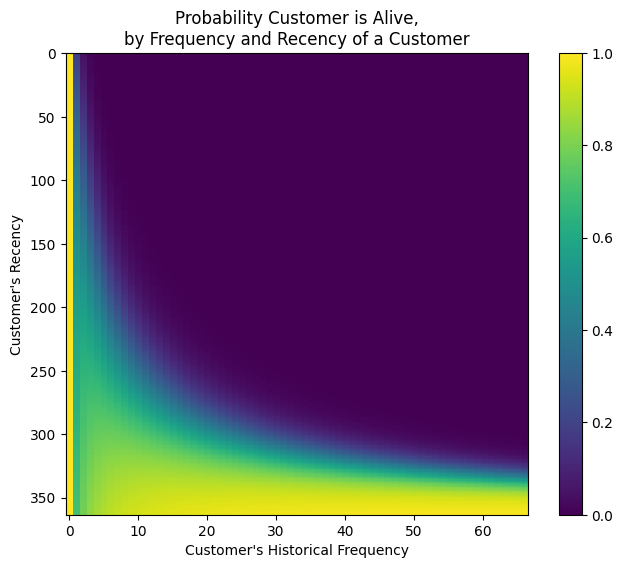

In [ ]:
fig = plt.figure(figsize = (8,6))
plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

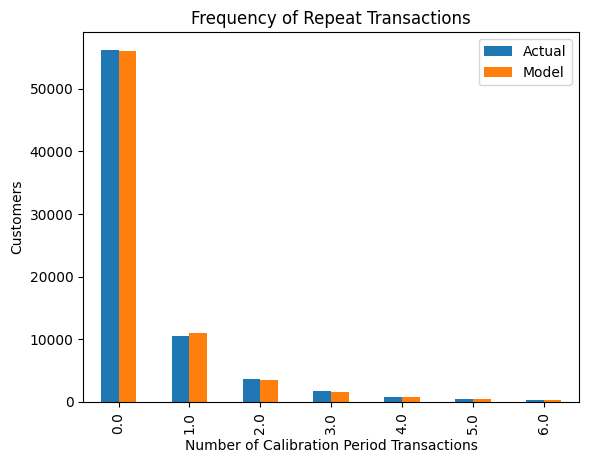

In [ ]:
plot_period_transactions(bgf)

In [ ]:
summary.shape

(74061, 6)

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  
71806           0.582699

### Predicting Future Transactions

In [ ]:
# We will be predicting future transactions for the next 5 months i.e. 150 days (from Jan to May)
t=150

summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t,summary['frequency'],summary['recency'],summary['T']))
summary.sort_values(by='pred_num_txn',ascending=False).head(10).reset_index()

index Customer ID  frequency  recency      T  monetary_value  \
0  34437   886327069       66.0    343.0  353.0      711.432576   
1  12021    30318857       37.0    332.0  342.0      418.160000   
2  29271   885712208       34.0    348.0  357.0       94.011765   
3    223    10764661       31.0    340.0  340.0       68.942903   
4   5349   241537231       32.0    341.0  345.0      220.342500   
5   7965   242267747       32.0    331.0  343.0      675.191563   
6  15459    72364298       28.0    351.0  353.0      292.582143   
7  60035   887147254       11.0     94.0   96.0      792.442727   
8   1586    16684324       24.0    336.0  343.0       93.977500   
9  57259   887084992       13.0    125.0  128.0      284.022308   

   probability_alive  pred_num_txn  
0           0.947085          20.0  
1           0.952711          12.0  
2           0.957392          11.0  
3           0.977510          10.0  
4           0.970161          10.0  
5           0.943972          10.0  
6           0.971665           9.0  
7           0.932720           8.0  
8           0.956731           8.0  
9           0.938117           8.0

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  
71806           0.582699           1.0

In [ ]:
summary.shape

(74061, 7)

## Validation of BG/NBD

In [ ]:
summary_cal_holdout = calibration_and_holdout_data(df,
                                                   'Customer ID',
                                                   'Invoice Date',
                                                    calibration_period_end='2023-01-01',
                                                    observation_period_end='2023-06-01')

bgf.fit(summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['recency_cal'],
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 74061 subjects, a: 0.75, alpha: 57.90, b: 1.74, r: 0.22>

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

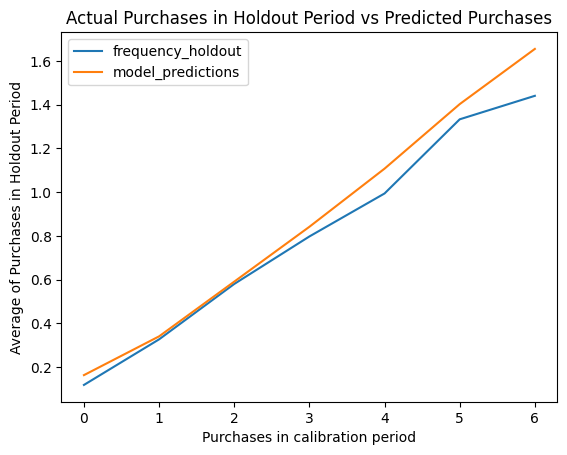

In [ ]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [ ]:
summary.shape

(74061, 7)

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  
71806           0.582699           1.0

## Gamma - Gamma Model

`Gamma - Gamma model is used to predict the monetary value that a consumer would add in the system`

Some of the key assumptions of the Gamma-Gamma model are:

1. The monetary value of a customer’s given transaction varies randomly around their average transaction value.

2. Average transaction value varies across customers but do not vary over time for any given customer.

3. The distribution of average transaction values across customers is independent of the transaction process.

### Filtering Return Buyers

In [ ]:
#From now on let's consider 17,617 (24% customers who are returning customers)
summary = summary[(summary['frequency']>0) & (summary['monetary_value']>0)]
print(summary.shape)

(17742, 7)


In [ ]:
summary['Customer ID'].nunique()

17742

In [ ]:
summary.head()

Customer ID  frequency  recency      T  monetary_value  probability_alive  \
0    10000058        1.0     35.0  214.0       21.990000           0.388803   
1    10000227        5.0    178.0  221.0       25.026000           0.765804   
3    10000657        9.0    344.0  362.0      814.436667           0.898887   
4    10000670        1.0    117.0  212.0        6.990000           0.580655   
5    10000719        1.0     22.0  126.0      457.980000           0.460074   

   pred_num_txn  
0           0.0  
1           2.0  
3           3.0  
4           0.0  
5           0.0

In [ ]:
summary.shape

(17742, 7)

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  
71806           0.582699           1.0

### Gamma - Gamma Assumption Check

In [ ]:
#The assumption check
#The distribution of average transaction values across customers is independent of the transaction process.
# We check correlation between frequency and monetary value
summary[['frequency','monetary_value']].corr()

#very week correlation hence our data satisfies our assumption

frequency  monetary_value
frequency        1.000000        0.031223
monetary_value   0.031223        1.000000

### Fitting the Gamma - Gamma Model

In [ ]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.0001)
ggf.fit(summary['frequency'],summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 17742 subjects, p: 4.55, q: 0.85, v: 14.12>

In [ ]:
ggf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
p   4.554267  0.098724         4.360768         4.747766
q   0.846954  0.008467         0.830359         0.863549
v  14.123074  0.382741        13.372902        14.873247

### Predicitng Average Annual Sales

In [ ]:
summary['expected_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],summary['monetary_value'])
summary.head()

Customer ID  frequency  recency      T  monetary_value  probability_alive  \
0    10000058        1.0     35.0  214.0       21.990000           0.388803   
1    10000227        5.0    178.0  221.0       25.026000           0.765804   
3    10000657        9.0    344.0  362.0      814.436667           0.898887   
4    10000670        1.0    117.0  212.0        6.990000           0.580655   
5    10000719        1.0     22.0  126.0      457.980000           0.460074   

   pred_num_txn  expected_avg_sales  
0           0.0           37.368853  
1           2.0           28.039065  
3           3.0          819.064188  
4           0.0           21.847250  
5           0.0          488.519761

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  expected_avg_sales  
71806           0.582699           1.0          166.670576

In [ ]:
summary.shape

(17742, 8)

In [ ]:
print('Expected Average Sales:',summary['expected_avg_sales'].mean())
print('Actual Sales:',summary['monetary_value'].mean())

Expected Average Sales: 306.205441300481
Actual Sales: 288.2252122913111


**discount_rate ** parameter is based on the concept of DCF (discounted cash flow), where you will discount the future monetary value by a discount rate to get the present value of that cash flow.


In [ ]:
summary['predicted_clv'] = ggf.customer_lifetime_value(bgf,summary['frequency'],
                                                       summary['recency'],
                                                       summary['T'],
                                                       summary['monetary_value'],
                                                       time=5, #lifetime in months
                                                       freq='D', #frequency of data in the dataset
                                                       discount_rate=0.1 #parameter
                                                       )
summary.head()

Customer ID  frequency  recency      T  monetary_value  probability_alive  \
0    10000058        1.0     35.0  214.0       21.990000           0.388803   
1    10000227        5.0    178.0  221.0       25.026000           0.765804   
3    10000657        9.0    344.0  362.0      814.436667           0.898887   
4    10000670        1.0    117.0  212.0        6.990000           0.580655   
5    10000719        1.0     22.0  126.0      457.980000           0.460074   

   pred_num_txn  expected_avg_sales  predicted_clv  
0           0.0           37.368853       6.612379  
1           2.0           28.039065      39.837895  
3           3.0          819.064188    1662.657527  
4           0.0           21.847250       5.821817  
5           0.0          488.519761     145.062123

In [ ]:
summary['mannual_predicted_clv'] = summary['pred_num_txn'] * summary['expected_avg_sales']
summary.head()

Customer ID  frequency  recency      T  monetary_value  probability_alive  \
0    10000058        1.0     35.0  214.0       21.990000           0.388803   
1    10000227        5.0    178.0  221.0       25.026000           0.765804   
3    10000657        9.0    344.0  362.0      814.436667           0.898887   
4    10000670        1.0    117.0  212.0        6.990000           0.580655   
5    10000719        1.0     22.0  126.0      457.980000           0.460074   

   pred_num_txn  expected_avg_sales  predicted_clv  mannual_predicted_clv  
0           0.0           37.368853       6.612379               0.000000  
1           2.0           28.039065      39.837895              56.078130  
3           3.0          819.064188    1662.657527            2457.192565  
4           0.0           21.847250       5.821817               0.000000  
5           0.0          488.519761     145.062123               0.000000

In [ ]:
summary.shape

(17742, 10)

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  expected_avg_sales  predicted_clv  \
71806           0.582699           1.0          166.670576     172.193491   

       mannual_predicted_clv  
71806             166.670576

## Buisness Usage Tools

### Putting in final Profit margin for biz into calculations


In [ ]:
profit_margin = 0.2 #taken 20% margin

summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.tail()

Customer ID  frequency  recency      T  monetary_value  \
74046   993764755        1.0     83.0  234.0        189.0000   
74047   993765269        2.0     54.0  156.0         87.9750   
74049   993765310        2.0    159.0  322.0       2662.9850   
74051   993765604        8.0    300.0  338.0        236.2475   
74052   993765923        1.0    144.0  349.0        159.0000   

       probability_alive  pred_num_txn  expected_avg_sales  predicted_clv  \
74046           0.491864           0.0          210.186379      44.150117   
74047           0.469562           1.0           96.660676      45.892374   
74049           0.517799           0.0         2715.676640     848.689525   
74051           0.839041           2.0          239.016903     425.930920   
74052           0.500200           0.0          179.143173      28.166706   

       mannual_predicted_clv         CLV  
74046               0.000000    8.830023  
74047              96.660676    9.178475  
74049               0.000000  169.737905  
74051             478.033807   85.186184  
74052               0.000000    5.633341

In [ ]:
summary.shape
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  expected_avg_sales  predicted_clv  \
71806           0.582699           1.0          166.670576     172.193491   

       mannual_predicted_clv        CLV  
71806             166.670576  34.438698

### Predicting CLV for individual customers

In [ ]:
t = 150
individual = summary.loc[summary['Customer ID'] == 993764280]
bgf.predict(t,
            individual['frequency'],
            individual['recency'],
            individual['T'])


Series([], dtype: float64)

In [ ]:
summary.shape

(17742, 11)

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  expected_avg_sales  predicted_clv  \
71806           0.582699           1.0          166.670576     172.193491   

       mannual_predicted_clv        CLV  
71806             166.670576  34.438698

### Projecting Customer History and Probability Alive

In [ ]:
example_customer_orders = df_2022.loc[df_2022['Customer ID'] == '993764280']
example_customer_orders

ˇItem Name Item Sub Category  \
80957   Electronic Audio Experiments Longsword Distort...         Guitar FX   
80958   Electronic Audio Experiments LimeLight v2 OP O...         Guitar FX   
80959   Electronic Audio Experiments Halberd V2 Overdr...         Guitar FX   
80960   Browne Amplification The Protein Dual Overdriv...         Guitar FX   
169623  ThorpyFX The Dane - 'Danish' Pete Honore Signa...         Guitar FX   
169624           Boss case for Waza-Air and Waza-Air Bass         Guitar FX   
169625                    Boss Waza Air Katana Headphones         Guitar FX   
169630  XSONIC AIRSTEP Smart MIDI Controller Footswitc...         Guitar FX   
169631  Browne Amplification The Protein Dual Overdriv...         Guitar FX   
169632                    Animals Pedals BATH TIME REVERB         Guitar FX   
169633                       Animals Pedals Rust Rod Fuzz         Guitar FX   
169634  Great Eastern FX Co Small Speaker Overdrive Pedal         Guitar FX   
169635  SolidGoldFX Commodore Breaker-Style Low to Mid...         Guitar FX   

       Item Category   UK Region Postcode district  Product code  \
80957        GUITARS  North East         Newcastle        EA-LSD   
80958        GUITARS  North East         Newcastle       EA-LLV2   
80959        GUITARS  North East         Newcastle        EA-HBD   
80960        GUITARS  North East         Newcastle  PROTEINBLACK   
169623       GUITARS  North East         Newcastle       THEDANE   
169624       GUITARS  North East         Newcastle  WAZAAIR-CASE   
169625       GUITARS  North East         Newcastle       WAZAAIR   
169630       GUITARS  North East         Newcastle     AIRSTEPBW   
169631       GUITARS  North East         Newcastle  PROTEINBLACK   
169632       GUITARS  North East         Newcastle       AP-BATH   
169633       GUITARS  North East         Newcastle       AP-RUST   
169634       GUITARS  North East         Newcastle      GEFX-SSO   
169635       GUITARS  North East         Newcastle      SG-CMDRE   

                               Brand Sale type   Order ID  Paid Gross  \
80957                          Other       Web  886770162      249.00   
80958   Electronic Audio Experiments       Web  886782997      229.00   
80959   Electronic Audio Experiments       Web  886660866      249.00   
80960           Browne Amplification       Web  886751869      319.00   
169623                      ThorpyFX       Web  887311453      265.00   
169624                          Boss       Web  887310268       24.99   
169625                          Boss       Web  887310268      319.00   
169630                        XSonic       Web  887328350      129.00   
169631          Browne Amplification       Web  887122193      319.00   
169632                Animals Pedals       Web  887066887      129.00   
169633                Animals Pedals       Web  887066887      129.00   
169634          Great Eastern FX Co.       Web  887030765      219.00   
169635                   SolidGoldFX       Web  886852901      199.00   

        Paid Net  Item Discount Net  Item Qty Customer ID        Invoice Date  \
80957     207.50                0.0         1   993764280 2022-02-24 00:00:00   
80958     190.83                0.0         1   993764280 2022-03-03 00:00:00   
80959     207.50                0.0         1   993764280 2022-01-06 00:00:00   
80960     265.83                0.0         1   993764280 2022-02-15 00:00:00   
169623    220.83                0.0         1   993764280 2022-12-12 15:28:00   
169624     20.82                0.0         1   993764280 2022-12-12 12:58:00   
169625    265.83                0.0         1   993764280 2022-12-12 12:58:00   
169630    107.50                0.0         1   993764280 2022-12-19 10:37:00   
169631    265.83                0.0         1   993764280 2022-09-11 11:27:00   
169632    107.50                0.0         1   993764280 2022-08-10 11:17:00   
169633    107.50                0.0         1   993764280 2022-08-10 11:1

In [ ]:
df_orders = pd.DataFrame(example_customer_orders[['Order ID', 'Customer ID', 'Paid Gross', 'Invoice Date']])
df_orders

Order ID Customer ID  Paid Gross        Invoice Date
80957   886770162   993764280      249.00 2022-02-24 00:00:00
80958   886782997   993764280      229.00 2022-03-03 00:00:00
80959   886660866   993764280      249.00 2022-01-06 00:00:00
80960   886751869   993764280      319.00 2022-02-15 00:00:00
169623  887311453   993764280      265.00 2022-12-12 15:28:00
169624  887310268   993764280       24.99 2022-12-12 12:58:00
169625  887310268   993764280      319.00 2022-12-12 12:58:00
169630  887328350   993764280      129.00 2022-12-19 10:37:00
169631  887122193   993764280      319.00 2022-09-11 11:27:00
169632  887066887   993764280      129.00 2022-08-10 11:17:00
169633  887066887   993764280      129.00 2022-08-10 11:17:00
169634  887030765   993764280      219.00 2022-07-21 14:57:00
169635  886852901   993764280      199.00 2022-04-12 10:08:00

In [ ]:
summary.shape

(17742, 11)

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  expected_avg_sales  predicted_clv  \
71806           0.582699           1.0          166.670576     172.193491   

       mannual_predicted_clv        CLV  
71806             166.670576  34.438698

In [ ]:
summary.iloc[17087]

Customer ID              993304712
frequency                      3.0
recency                      240.0
T                            362.0
monetary_value           72.826667
probability_alive          0.62788
pred_num_txn                   1.0
expected_avg_sales        78.41271
predicted_clv            39.126591
mannual_predicted_clv     78.41271
CLV                       7.825318
Name: 72165, dtype: object

<Axes: title={'center': 'History of P_alive'}, ylabel='P_alive'>

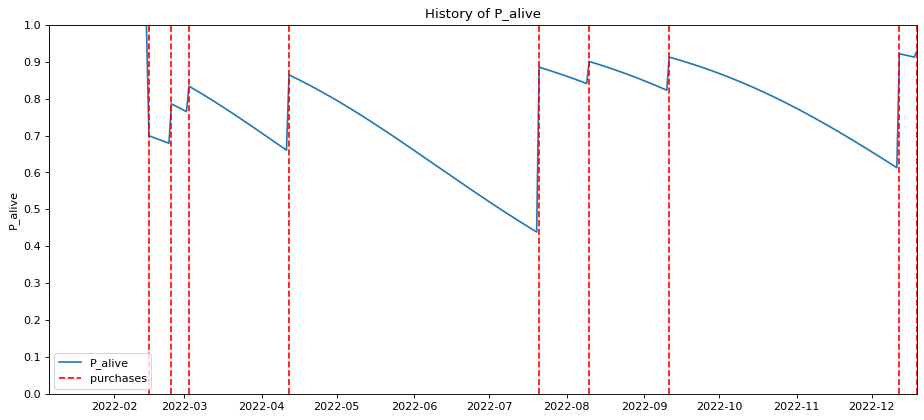

In [ ]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 200 #A datediff could be used from a particular date

plot_history_alive(bgf, days_since_birth, example_customer_orders, 'Invoice Date')

In [ ]:
summary[summary['Customer ID'] == '993219139']

Customer ID  frequency  recency      T  monetary_value  \
71806   993219139        7.0    257.0  359.0      163.852857   

       probability_alive  pred_num_txn  expected_avg_sales  predicted_clv  \
71806           0.582699           1.0          166.670576     172.193491   

       mannual_predicted_clv        CLV  
71806             166.670576  34.438698

## Exporting Data & Model Results

In [ ]:
#Saving Data
summary.to_csv('model_summary_cltv.csv')

In [ ]:
df_2022.to_csv('df_2022.csv')

In [ ]:
#Saving My Models
joblib.dump(bgf , 'model_bgf')

['model_bgf']

In [ ]:
joblib.dump(ggf , 'model_ggf')

['model_ggf']

In [ ]:
df_2022[df_2022["Customer ID"]=='1029013530']

ˇItem Name  \
209281  Gibson USA SG Tribute Vintage Cherry Satin Nic...   
209282  PRS Limited Edition CE24 Charcoal Satin - Blac...   
209283  Origin Effects RD Compact Hot Rod Overdrive Pedal   
209284  Victory V4 The Sheriff Guitar Amp Pedal TN-HP ...   
209285  Victory V4 The Sheriff Guitar Amp Pedal TN-HP ...   
209286         Marshall SC20H Studio Classic 20w amp head   
209287                Tourtech 10ft / 3m Instrument Cable   
209288           Orange Dark Terror 15w Valve Guitar Head   
209289                    Jim Dunlop Slide - Chrome large   
209290  TOURTECH TTS-GA108BK Acoustic / Electric Guita...   

           Item Sub Category Item Category       UK Region Postcode district  \
209281      Electric Guitars       GUITARS  Greater London          Kingston   
209282      Electric Guitars       GUITARS  Greater London          Kingston   
209283             Guitar FX       GUITARS  Greater London          Kingston   
209284  Guitar Amps and Cabs       GUITARS  Greater London          Kingston   
209285  Guitar Amps and Cabs       GUITARS  Greater London          Kingston   
209286  Guitar Amps and Cabs       GUITARS  Greater London          Kingston   
209287    Guitar Accessories       GUITARS  Greater London          Kingston   
209288  Guitar Amps and Cabs       GUITARS  Greater London          Kingston   
209289    Guitar Accessories       GUITARS  Greater London          Kingston   
209290    Guitar Accessories       GUITARS  Greater London          Kingston   

          Product code           Brand Sale type   Order ID  Paid Gross  \
209281     SGTR00AYNH1          Gibson       Web  887112572      949.00   
209282     CE24STEALTH             PRS       Web  887347384     1499.00   
209283          RDC-HR  Origin Effects       Web  887250906      319.00   
209284  SHERV4AMPTN-HP         Victory       Web  887208369      849.00   
209285  SHERV4AMPTN-HP         Victory       Web  887208369      849.00   
209286           SC20H        Marshall     Store   17249217      869.00   
209287        TTIC-3DL        Tourtech       Web  886773355       15.98   
209288      DARKTERROR          Orange       Web  886773355      379.00   
209289          JD-318      Jim Dunlop       Web  886773355       11.99   
209290     TTS-GA108BK        Tourtech       Web  886978358       11.99   

        Paid Net  Item Discount Net  Item Qty Customer ID        Invoice Date  \
209281    790.83                0.0         1  1029013530 2022-09-05 11:58:00   
209282   1249.17                0.0         1  1029013530 2022-12-27 14:58:00   
209283    265.83                0.0         1  1029013530 2022-11-21 09:37:00   
209284    707.50                0.0         1  1029013530 2022-10-30 13:47:00   
209285    707.50                0.0         1  1029013530 2022-10-30 13:47:00   
209286    724.17                0.0         1  1029013530 2022-11-27 11:07:00   
209287     13.32                0.0         2  1029013530 2022-02-26 00:00:00   
209288    315.83                0.0         1  1029013530 2022-02-26 00:00:00   
209289      9.99                0.0         1  1029013530 2022-02-26 00:00:00   
209290      9.99                0.0         1  1029013530 2022-06-23 11:27:00   

        Delivery Net ga:sourceMedium - Split 3 Extracted Invoice Date  
209281          0.00                   organic             2022/09/05  
209282          0.00                       NaN             2022/12/27  
209283          0.00                   organic             2022/11/21  
209284          0.00                   organic             2022/10/30  
209285          0.00                   organic             2022/10/30  
209286           NaN                       NaN             2022/11/27  
209287          0.00                       NaN             2022/02/26  
209288          0.00                       NaN             2022/02/26  
209289          0.00                       NaN             2022/02/26  
209290          4.16                       NaN          

## Building Web App with Streamlit

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

Overwriting app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

34.29.206.250


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.29.206.250:8501

npx: installed 22 in 4.595s
your url is: https://dry-paths-play.loca.lt
/content/app.py:15: DtypeWarning: Columns (0,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('df_2022.csv')
2024-02-06 17:48:36.540 Uncaught app exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/streamlit/runtime/scriptrunner/script_runner.py", line 535, in _run_script
    exec(code, module.__dict__)
  File "/content/app.py", line 110, in <module>
    first_tran_date = min(customer_orders['Extracted Invoice Date'])
ValueError: min() arg is an empty sequence
/content/app.py:15: DtypeWarning: Columns (0,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('df_2022.csv')
2024-02-06 17:48:58.147 Uncaught app exception
Traceback (most rec